In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Define dataset path and expected file name
dataset_dir = "./datasets"
dataset_zip = os.path.join(dataset_dir, "dogs-vs-cats.zip")

# Check if dataset already exists
if not os.path.exists(dataset_zip) and not os.path.exists(os.path.join(dataset_dir, "train")):
    print("Dataset not found. Downloading...")
    
    # Initialize and authenticate
    api = KaggleApi()
    api.authenticate()

    # Download dataset
    api.competition_download_files("dogs-vs-cats", path=dataset_dir)
    
    print("Download complete.")
else:
    print("Dataset already exists. Skipping download.")

Dataset already exists. Skipping download.


In [2]:
import zipfile
train_file = os.path.join(dataset_dir, "train")
if not os.path.exists(train_file):
    with zipfile.ZipFile("./datasets/dogs-vs-cats.zip", "r") as zip_ref:
        zip_ref.extractall("./datasets/")
    with zipfile.ZipFile("./datasets/train.zip", "r") as zip_ref:
        zip_ref.extractall("./datasets/")
    with zipfile.ZipFile("./datasets/test1.zip", "r") as zip_ref:
        zip_ref.extractall("./datasets/")

In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path("./datasets/train")
new_base_dir = pathlib.Path("./datasets/cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

2025-03-04 12:24:42.053068: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 12:24:42.066095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741112682.078405  409910 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741112682.082157  409910 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 12:24:42.095748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [7]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [10]:
batched_dataset = dataset.batch(32)

In [11]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


I0000 00:00:1741112826.645362  410949 service.cc:148] XLA service 0x1455d400b4f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741112826.645395  410949 service.cc:156]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2025-03-04 12:27:06.701912: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741112826.816430  410949 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-04 12:27:08.155854: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


19/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5105 - loss: 0.7109 

I0000 00:00:1741112828.605576  410949 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5035 - loss: 0.7015

2025-03-04 12:27:10.716131: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 650.71MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.5035 - loss: 0.7014 - val_accuracy: 0.5140 - val_loss: 0.6907
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5543 - loss: 0.6975 - val_accuracy: 0.5450 - val_loss: 0.6810
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5584 - loss: 0.6896 - val_accuracy: 0.5020 - val_loss: 0.7251
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6232 - loss: 0.6616 - val_accuracy: 0.6170 - val_loss: 0.6431
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6724 - loss: 0.6022 - val_accuracy: 0.6350 - val_loss: 0.6441
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6935 - loss: 0.5877 - val_accuracy: 0.6290 - val_loss: 0.6631
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7178 - loss: 0.5537 - val_accuracy: 0.6860 - val_loss: 0.5866
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7395 - loss: 0.5207 - val_accuracy: 0.6420 - val_loss: 0.

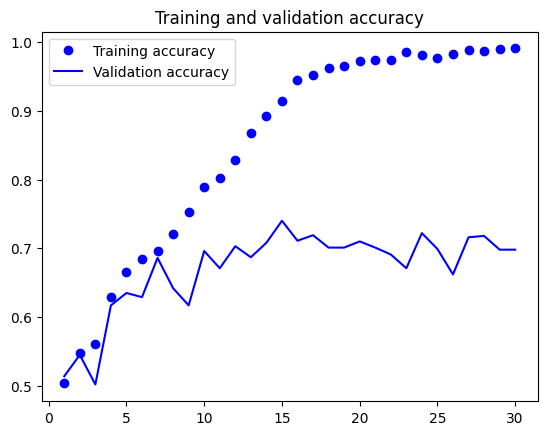

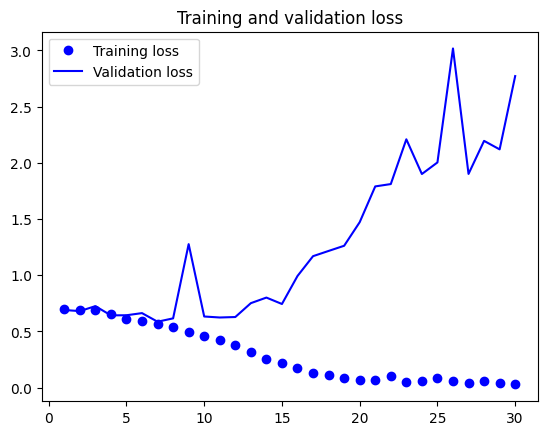

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [14]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6932 - loss: 0.5754  
Test accuracy: 0.689


In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [17]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100


2025-03-04 12:29:57.463044: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 650.71MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5061 - loss: 0.7253 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5141 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6980
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5077 - loss: 0.6945 - val_accuracy: 0.5050 - val_loss: 0.6889
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5502 - loss: 0.6916 - val_accuracy: 0.5190 - val_loss: 0.6907
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5732 - loss: 0.6854 - val_accuracy: 0.6190 - val_loss: 0.6658
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6040 - loss: 0.6680 - val_accuracy: 0.5450 - val_loss: 0.6843
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6230 - loss: 0.6560 - val_accuracy: 0.6380 - val_loss: 0.6347
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6446 - loss: 0.6383 - val_accuracy: 0.6760 - val_l

In [19]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8134 - loss: 0.4457   
Test accuracy: 0.818


In [20]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

2025-03-04 12:32:14.606734: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 281.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-04 12:32:14.630196: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 281.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-04 12:32:14.644954: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 791.27MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-04 12:32:14.644977: W external/local_xla/

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/sw/eb/sw/Python/3.10.8-GCCcore-12.2.0/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/sw/eb/sw/Python/3.10.8-GCCcore-12.2.0/lib/python3.10/runpy.py", line 86, in _run_code

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/sw/eb/sw/Python/3.10.8-GCCcore-12.2.0/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/sw/eb/sw/Python/3.10.8-GCCcore-12.2.0/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once

  File "/sw/eb/sw/Python/3.10.8-GCCcore-12.2.0/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/job.23603/ipykernel_409910/710858949.py", line 13, in <module>

  File "/tmp/job.23603/ipykernel_409910/710858949.py", line 8, in get_features_and_labels

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict

  File "/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.40 = (f32[32,64,180,180]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,180,180]{3,2,1,0} %get-tuple-element.26, f32[64,64,3,3]{3,2,1,0} %bitcast.360, f32[64]{0} %arg4.5), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="vgg16_1/block1_conv2_1/convolution" source_file="/ztank/scratch/user/u.ks124812/CSCE636/venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 282198016 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_85691]